In [1]:
import torch
from Interfaces import DKLasso

C:\Users\Yixiao\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision
from torch.utils import data
from torchvision import transforms
import numpy as np

In [3]:
def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 2

def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))


def load_data_mnist(batch_size, resize=None):
    """Download the MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.MNIST(
        root="data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))


def load_subset_mnist(resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.MNIST(
        root="data", train=True, transform=trans, download=False)
    idx = (mnist_train.targets==5) | (mnist_train.targets==6)
    mnist_train.targets = mnist_train.targets[idx]
    mnist_train.data = mnist_train.data[idx]
    mnist_train.data = mnist_train.data.float()
    mnist_train.data = torch.reshape(torch.flatten(mnist_train.data), (len(mnist_train.data), 784))
    
    # idx = mnist_train.targets == 5
    # idx += mnist_train.targets == 6
    # subset_train = torch.utils.data.dataset.Subset(mnist_train, np.where(idx==True)[0])
    # subset_train.data = mnist_train.data[np.where(idx==True)[0]]
    # subset_train.targets = mnist_train.targets[np.where(idx==True)[0]]
    
    idx = mnist_train.targets == 5
    mnist_train.targets[idx] = 0
    idx = mnist_train.targets == 6
    mnist_train.targets[idx] = 1


    mnist_test = torchvision.datasets.MNIST(
        root="data", train=False, transform=trans, download=False)
    idx = (mnist_test.targets==5) | (mnist_test.targets==6)
    mnist_test.targets = mnist_test.targets[idx]
    mnist_test.data = mnist_test.data[idx]
    mnist_test.data = mnist_test.data.float()
    mnist_test.data = torch.reshape(torch.flatten(mnist_test.data), (len(mnist_test.data), 784))
    
    idx = mnist_test.targets == 5
    mnist_test.targets[idx] = 0
    idx = mnist_test.targets == 6
    mnist_test.targets[idx] = 1
    
    # idx1 = mnist_test.targets == 5
    # labels1 = (0,)*len(np.where(idx1==True)[0])
    # idx2 = mnist_test.targets == 6
    # labels2 = (1,)*len(np.where(idx2==True)[0])
    # idx = np.concatenate([np.where(idx1==True)[0], np.where(idx2==True)[0]], axis=None)
    # labels = labels1 + labels2
    # subset_test = custom_subset(mnist_test, indices=idx, labels=labels)
    
    # return (data.DataLoader(mnist_train, batch_size, shuffle=True,
    #                         num_workers=get_dataloader_workers()),
    #         data.DataLoader(mnist_test, batch_size, shuffle=True,
    #                         num_workers=get_dataloader_workers()))
    return (mnist_train, mnist_test)



In [4]:
mnist_train, mnist_test = load_subset_mnist()

In [5]:
train_x, train_y = mnist_train.data, mnist_train.targets
test_x, test_y = mnist_test.data, mnist_test.targets

In [6]:
train_x = train_x / 255
test_x = test_x / 255

In [7]:
seed=14514

In [8]:
import gc

rep = 3

DKLassoObj_list = []
path_list = []
for i in range(rep):
    print("\n",i)
    
    DKLassoObj = DKLasso(method="Classifier",
                    hidden_dims=(1024,512,128,16),
                    lambda_start=None,
                    lambda_max=float("inf"),
                    lambda_shrinkage=1.0,
                    path_multiplier=(1.03,1.01),
                    gamma=1e-2,
                    gamma_skip=0,
                    M=10,
                    dropout=(0.3,),
                    lr=(1e-3, 1e-3),
                    n_epochs=(1500, 150),
                    patience=(20, 2),
                    offset=(20, 1),
                    grid_size=200,
                    training_batch_size=1024,
                    test_size=0.09,
                    device=None,
                    verbose=0,
                    random_state=seed+1000,
                    torch_seed=seed+10000)
    
    %time path = DKLassoObj.train_path(x=train_x, y=train_y)
    
    DKLassoObj_list.append(DKLassoObj)
    path_list.append(path)
    
    DKLassoObj=None
    path=None
    gc.collect()
    torch.cuda.empty_cache()


 0

Initialized dense DKL model
40 epochs, train_loss (NMLL) 4.396e+00, test_loss (Err) 4.419e+00, test_accuracy 0.995, l2_reg 4.387e+02, l2_reg_skip 4.305e+00, l1_reg_skip 5.125e+01
CPU times: total: 19min 43s
Wall time: 25min 12s

 1

Initialized dense DKL model
40 epochs, train_loss (NMLL) 4.295e+00, test_loss (Err) 4.314e+00, test_accuracy 0.995, l2_reg 4.280e+02, l2_reg_skip 4.089e+00, l1_reg_skip 4.959e+01
CPU times: total: 17min 29s
Wall time: 22min 33s

 2

Initialized dense DKL model
40 epochs, train_loss (NMLL) 4.529e+00, test_loss (Err) 4.556e+00, test_accuracy 0.994, l2_reg 4.525e+02, l2_reg_skip 4.162e+00, l1_reg_skip 5.030e+01
CPU times: total: 16min 33s
Wall time: 22min 43s


In [30]:
import gpytorch
import torch
import math

def cal_pred_error(path, DKLassoObj, x, y):
    model = DKLassoObj.model.to("cuda")
    likelihood = DKLassoObj.likelihood.to("cuda")
    test_x = x.to("cuda")
    test_y = y.to("cuda")
    
    def cross_entropy(probs, y):
        return -torch.log(probs[range(len(probs)), y])
    
    
    # model.load_state_dict(path[-1].state_dict)
    # likelihood.load_state_dict(path[-1].likelihood_state_dict)
    # with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.num_likelihood_samples(64):
    #     pred_dist = likelihood(model(test_x))
    #     pred_probs = pred_dist.probs.mean(0)
    # if type == "CE":
    #     error_bottomline = torch.mean(cross_entropy(pred_probs, test_y)).item()
    # elif type == "ACC":
    #     pred_class = pred_probs.argmax(-1)
    #     correct = pred_class.eq(test_y.view_as(pred_class)).cpu().sum()
    #     error_bottomline = float(correct) / float(test_y.numel())

    
    selected = math.ceil(path[0].selected.sum().item()*1.05)
    model.load_state_dict(path[0].state_dict)
    likelihood.load_state_dict(path[0].likelihood_state_dict)
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.num_likelihood_samples(64):
        pred_dist = likelihood(model(test_x))
        pred_probs = pred_dist.probs.mean(0)
        
    pred_class = pred_probs.argmax(-1)
    correct = pred_class.eq(test_y.view_as(pred_class)).cpu().sum()
    acc = float(correct) / float(test_y.numel())
        
    ce = torch.mean(cross_entropy(pred_probs, test_y)).item()
        
    num_selected = [selected]
    best_ce = [ce]
    best_acc = [acc]
    path_idx = [0]
    for i in range(1,len(path)):
        selected = path[i].selected.sum().item()
        model.load_state_dict(path[i].state_dict)
        likelihood.load_state_dict(path[i].likelihood_state_dict)
        with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.num_likelihood_samples(64):
            pred_dist = likelihood(model(test_x))
            pred_probs = pred_dist.probs.mean(0)

        ce = torch.mean(cross_entropy(pred_probs, test_y)).item()

        pred_class = pred_probs.argmax(-1)
        correct = pred_class.eq(test_y.view_as(pred_class)).cpu().sum()
        acc = float(correct) / float(test_y.numel())
        
        if selected in num_selected:
            slt_idx = num_selected.index(selected)

            if ce < best_ce[slt_idx]:
                best_ce[slt_idx] = ce
                best_acc[slt_idx] = acc
                path_idx[slt_idx] = i
        else:
            if selected == 0:
                num_selected.append(selected)
                best_ce.append(ce)
                best_acc.append(acc)
                path_idx.append(i)
            else:
                if acc >= 0.9:
                    num_selected.append(selected)
                    best_ce.append(ce)
                    best_acc.append(acc)
                    path_idx.append(i)
            
        sort_idx = sorted(range(len(num_selected)), key=lambda k: num_selected[k], reverse=True)
        num_selected = [num_selected[k] for k in sort_idx]
        best_ce = [best_ce[k] for k in sort_idx]
        best_acc = [best_acc[k] for k in sort_idx]
        path_idx = [path_idx[k] for k in sort_idx]
        
    return num_selected, best_ce, best_acc, path_idx

In [31]:
selected_list = []
ce_list = []
acc_list = []

for i in range(rep):
    print(i)
    
    num_selected, ce_error, acc_error, path_idx = cal_pred_error(path=path_list[i], DKLassoObj=DKLassoObj_list[i], x=test_x, y=test_y)
    selected_list.append(num_selected)
    ce_list.append(ce_error)
    acc_list.append(acc_error)


0
1
2


In [ ]:
ce_selected_list = []
ce_list = []

acc_selected_list = []
acc_list = []

for i in range(rep):
    print(i)
    
    ce_selected, ce_error, ce_path_idx = cal_pred_error(path=path_list[i], DKLassoObj=DKLassoObj_list[i], x=test_x, y=test_y, type="CE")
    ce_selected_list.append(ce_selected)
    ce_list.append(ce_error)
    
    acc_selected, acc_error, acc_path_idx = cal_pred_error(path=path_list[i], DKLassoObj=DKLassoObj_list[i], x=test_x, y=test_y, type="ACC")
    acc_selected_list.append(acc_selected)
    acc_list.append(acc_error)
    

Text(0.5, 1.0, 'Cross Entropy')

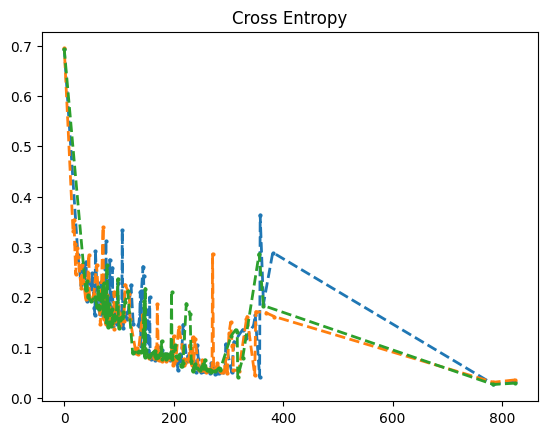

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(len(path_list)):
    ax.plot(selected_list[i], ce_list[i], marker='o', linestyle='dashed', linewidth=2, markersize=2)
plt.title("Cross Entropy")

Text(0.5, 1.0, 'Classification Accuracy')

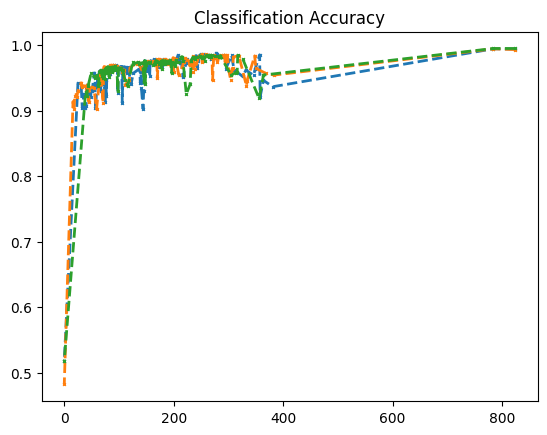

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(len(path_list)):
    ax.plot(selected_list[i], acc_list[i], marker='x', linestyle='dashed', linewidth=2, markersize=2)
plt.title("Classification Accuracy")

In [34]:
import scipy
import numpy

def find_mean_ci(num_reps, selected_list, error_list):
    processed_selected = []
    processed_error_mean = []
    processed_error_lb = []
    processed_error_ub = []
    for i in range(825):
        count = 0
        for j in range(num_reps):
            if i in selected_list[j]:
                count += 1
        if count >= 3:
            tmp = []
            for j in range(num_reps):
                if i in selected_list[j]:
                    slt_idx = selected_list[j].index(i)
                    tmp.append(error_list[j][slt_idx])
                    
            tval = scipy.stats.t.ppf(q=0.975, df=len(tmp)-1)
            stand_err = numpy.std(tmp)/numpy.sqrt(len(tmp))
            
            err_mean = numpy.mean(tmp)
            err_lb = err_mean - tval*stand_err
            err_ub = err_mean + tval*stand_err
            
            processed_selected.append(i)
            processed_error_mean.append(err_mean)
            processed_error_lb.append(err_lb)
            processed_error_ub.append(err_ub)
    return processed_selected, processed_error_mean, processed_error_lb, processed_error_ub

Text(0.5, 1.0, 'Mean Cross Entropy')

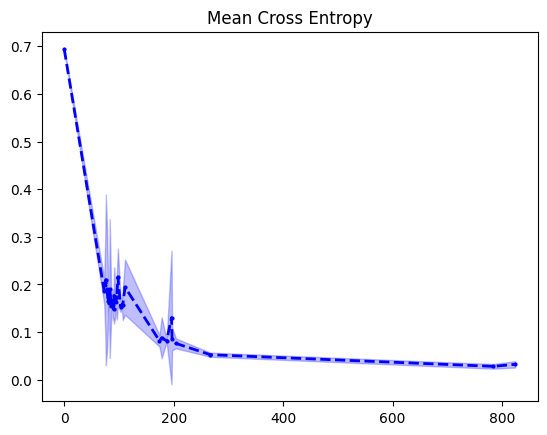

In [35]:
ce_slt, ce_mean, ce_lb, ce_ub = find_mean_ci(num_reps=rep, selected_list=selected_list, error_list=ce_list)
acc_slt, acc_mean, acc_lb, acc_ub = find_mean_ci(num_reps=rep, selected_list=selected_list, error_list=acc_list)


fig, ax = plt.subplots()
Non_additive, = ax.plot(ce_slt, ce_mean, marker='o', linestyle='dashed', linewidth=2, markersize=2, color="blue")
ax.fill_between(ce_slt, ce_lb, ce_ub, alpha=0.25, color="blue")
plt.title("Mean Cross Entropy")

Text(0.5, 1.0, 'Mean Accuracy')

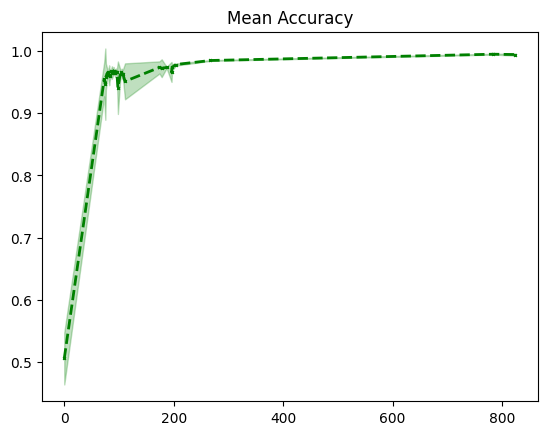

In [36]:
fig, ax = plt.subplots()
Non_additive, = ax.plot(acc_slt, acc_mean, marker='x', linestyle='dashed', linewidth=2, markersize=2, color="green")
ax.fill_between(acc_slt, acc_lb, acc_ub, alpha=0.25, color="green")
plt.title("Mean Accuracy")

1
2


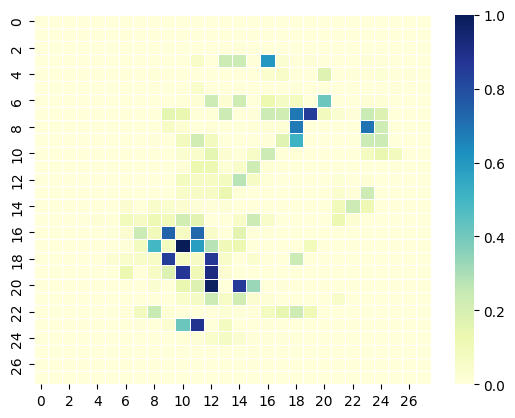

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

imp = DKLassoObj_list[0].feature_importances.reshape((28, 28))
imp -= imp.min()
imp /= imp.max()
for i in range(1,rep):
    print(i)
    imp_tmp = DKLassoObj_list[i].feature_importances.reshape((28, 28))
    imp_tmp -= imp_tmp.min()
    imp_tmp /= imp_tmp.max()
    
    imp += imp_tmp

imp /= rep
ax = sns.heatmap(imp, linewidth=0.5, cmap="YlGnBu")
plt.show()

In [42]:
tmp=DKLassoObj.model.feature_extractor(test_x.to("cuda"))

In [44]:
tmp2=tmp.transpose(-1, -2).unsqueeze(-1)

In [48]:
tmp

tensor([[ 0.8044,  0.4594, -0.3413,  ...,  0.7080,  0.8600,  0.2797],
        [ 0.8044,  0.4594, -0.3413,  ...,  0.7080,  0.8600,  0.2797],
        [ 0.8044,  0.4594, -0.3413,  ...,  0.7080,  0.8600,  0.2797],
        ...,
        [ 0.8044,  0.4594, -0.3413,  ...,  0.7080,  0.8600,  0.2797],
        [ 0.8044,  0.4594, -0.3413,  ...,  0.7080,  0.8600,  0.2797],
        [ 0.8044,  0.4594, -0.3413,  ...,  0.7080,  0.8600,  0.2797]],
       device='cuda:0', grad_fn=<TanhBackward0>)

In [50]:
tmp2.shape

torch.Size([8, 1850, 1])

In [51]:
tmp2

tensor([[[ 0.8044],
         [ 0.8044],
         [ 0.8044],
         ...,
         [ 0.8044],
         [ 0.8044],
         [ 0.8044]],

        [[ 0.4594],
         [ 0.4594],
         [ 0.4594],
         ...,
         [ 0.4594],
         [ 0.4594],
         [ 0.4594]],

        [[-0.3413],
         [-0.3413],
         [-0.3413],
         ...,
         [-0.3413],
         [-0.3413],
         [-0.3413]],

        ...,

        [[ 0.7080],
         [ 0.7080],
         [ 0.7080],
         ...,
         [ 0.7080],
         [ 0.7080],
         [ 0.7080]],

        [[ 0.8600],
         [ 0.8600],
         [ 0.8600],
         ...,
         [ 0.8600],
         [ 0.8600],
         [ 0.8600]],

        [[ 0.2797],
         [ 0.2797],
         [ 0.2797],
         ...,
         [ 0.2797],
         [ 0.2797],
         [ 0.2797]]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [85]:
import gpytorch
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    output = DKLassoModel.likelihood(DKLassoModel.model(test_x))

In [160]:
torch.all(-(output.log_prob(test_y).mean(0))==(-output.log_prob(test_y)).mean(0))

tensor(True)

In [164]:
torch.mean((-output.log_prob(test_y)).mean(0))

tensor(0.6943)

In [98]:
gpytorch.metrics.negative_log_predictive_density(output, test_y)

tensor([[0.0004, 0.0003, 0.0004,  ..., 0.0003, 0.0004, 0.0003],
        [0.0004, 0.0003, 0.0004,  ..., 0.0003, 0.0004, 0.0003],
        [0.0004, 0.0003, 0.0004,  ..., 0.0003, 0.0004, 0.0003],
        ...,
        [0.0004, 0.0003, 0.0004,  ..., 0.0003, 0.0004, 0.0003],
        [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
        [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]])

In [87]:
def cross_entropy(logits, y):
    return -torch.log(logits[range(len(logits)), y])

In [153]:
output.probs[1].shape

torch.Size([1850, 2])

In [140]:
lp = cross_entropy(output.probs[0], test_y)
for i in range(1,10):
    lp+=cross_entropy(output.probs[i], test_y)
lp = lp/10

In [152]:
lp.shape

torch.Size([1850])

In [154]:
lp[0].item()

0.7552362680435181

In [155]:
(-(output.log_prob(test_y).mean(0)))[0].item()

0.7552362680435181

In [91]:
-torch.log(output.probs.mean(0)[0,0])

tensor(0.7535)

In [2]:
a = torch.arange(9, dtype= torch.float) - 4
b = a.reshape((3, 3))
b

tensor([[-4., -3., -2.],
        [-1.,  0.,  1.],
        [ 2.,  3.,  4.]])

In [3]:
torch.norm(b,p=1)

tensor(20.)

In [34]:
scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-10, 10)

In [37]:
scale_to_bounds(b)

tensor([[-9.5000, -7.1250, -4.7500],
        [-2.3750,  0.0000,  2.3750],
        [ 4.7500,  7.1250,  9.5000]])

In [ ]:
c = torch.nn.Flatten(b)
d = torch.flatten(b)

torch.reshape(torch.flatten(mnist_train.data[0:2]), (len(mnist_train.data[0:2]), 784))[1,:] == torch.flatten(mnist_train.data[1])

In [14]:
torch.flatten(b)

tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

In [12]:
from d2l import torch as d2l

def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def get_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

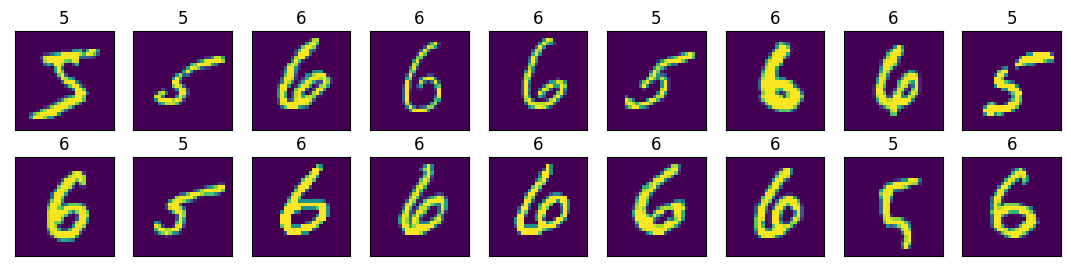

In [64]:
import numpy as np

# from torch.utils.data import Dataset
# class custom_subset(Dataset):
#     r"""
#     Subset of a dataset at specified indices.

#     Arguments:
#         dataset (Dataset): The whole Dataset
#         indices (sequence): Indices in the whole set selected for subset
#         labels(sequence) : targets as required for the indices. will be the same length as indices
#     """
#     def __init__(self, dataset, indices, labels):
#         self.dataset = torch.utils.data.Subset(dataset, indices)
#         self.targets = labels
#     def __getitem__(self, idx):
#         image = self.dataset[idx][0]
#         target = self.targets[idx]
#         return (image, target)
#     def __len__(self):
#         return len(self.targets)
    

trans = transforms.ToTensor()
# mnist_train = torchvision.datasets.FashionMNIST(
#     root="data", train=True, transform=trans, download=False)
mnist_train = torchvision.datasets.MNIST(
    root="data", train=True, transform=trans, download=False)
# Selecting classes 5 and 6
idx = (mnist_train.targets==5) | (mnist_train.targets==6)
mnist_train.targets = mnist_train.targets[idx]
mnist_train.data = mnist_train.data[idx]

# idx1 = mnist_train.targets == 5
# labels1 = (0,)*len(np.where(idx1==True)[0])
# idx2 = mnist_train.targets == 6
# labels2 = (1,)*len(np.where(idx2==True)[0])
# idx = np.concatenate([np.where(idx1==True)[0], np.where(idx2==True)[0]], axis=None)
# labels = labels1 + labels2
# subset_train = custom_subset(mnist_train, indices=idx, labels=labels)

# subset_train = torch.utils.data.dataset.Subset(mnist_train, np.where(idx==True)[0])
# subset_train.data = mnist_train.data[np.where(idx==True)[0]]
# subset_train.targets = mnist_train.targets[np.where(idx==True)[0]]

# mnist_test = torchvision.datasets.MNIST(
#     root="data", train=False, transform=trans, download=False)
# idx = mnist_test.targets == 5
# idx += mnist_test.targets == 6
# subset_test = torch.utils.data.dataset.Subset(mnist_test, np.where(idx==True)[0])
# subset_test.data = mnist_test.data[np.where(idx==True)[0]]
# subset_test.targets = mnist_test.targets[np.where(idx==True)[0]]

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_mnist_labels(y));